# Analyzing the domain shift among the hospital centers

In [1]:
import os
import json
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)
from tqdm import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# 1. Paths & constants
METADATA_CSV = "/home/E19_FYP_Domain_Gen_Data/metadata.csv"
PATCHES_DIR  = "/home/E19_FYP_Domain_Gen_Data/patches"
CONFIG_PATH  = "../BioMedClip/checkpoints/open_clip_config.json"
WEIGHTS_PATH = "../BioMedClip/checkpoints/open_clip_pytorch_model.bin"
MODEL_NAME   = "biomedclip_local"
CONTEXT_LENGTH = 256
BATCH_SIZE   = 64 
NUM_WORKERS  = 4
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BiomedCLIPDataset(Dataset):
    def __init__(self, df, preprocess):
        self.filepaths = df["filepath"].tolist()
        self.labels    = df["tumor"].astype(int).tolist()
        self.preproc   = preprocess

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img = Image.open(self.filepaths[idx]).convert("RGB")
        img = self.preproc(img)           # yields a torch.Tensor (C,H,W)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

def append_filename_and_filepath(df):
    df["filename"] = df.apply(
        lambda r: f"patch_patient_{r.patient:03d}_node_{r.node}_x_{r.x_coord}_y_{r.y_coord}.png",
        axis=1
    )
    df["filepath"] = df.apply(
        lambda r: os.path.join(
            PATCHES_DIR,
            f"patient_{r.patient:03d}_node_{r.node}",
            r.filename
        ), 
        axis = 1
    )
    return df


with open(CONFIG_PATH, "r") as f:
    cfg = json.load(f)
model_cfg, preproc_cfg = cfg["model_cfg"], cfg["preprocess_cfg"]

# register local config if needed
if (not MODEL_NAME.startswith(HF_HUB_PREFIX)
    and MODEL_NAME not in _MODEL_CONFIGS):
    _MODEL_CONFIGS[MODEL_NAME] = model_cfg

tokenizer = get_tokenizer(MODEL_NAME)
model, _, preprocess = create_model_and_transforms(
    model_name=MODEL_NAME,
    pretrained=WEIGHTS_PATH,
    **{f"image_{k}": v for k,v in preproc_cfg.items()}
)


model.to(DEVICE).eval()


random_state = 42
samples = 2048

# 2. Load metadata and filter center=0
metadata_df = pd.read_csv(METADATA_CSV, index_col=0)
metadata_df = append_filename_and_filepath(metadata_df)

train_df = metadata_df[metadata_df.split == 0].copy()

centers_ds = []
for i in range(4):
    centers_ds.append(BiomedCLIPDataset(train_df[train_df.center == i].sample(samples), preprocess))

/home/e19372/anaconda3/envs/biomedclip/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/e19372/anaconda3/envs/biomedclip/lib/python3.10/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/e19372/anaconda3/envs/biomedclip/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/e19372/anaconda3/envs/biomedclip/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` 

In [ ]:
# Preallocate lists to store results
centers_features = [[] for _ in range(len(centers_ds))]
centers_labels = [[] for _ in range(len(centers_ds))]

for i, ds in enumerate(centers_ds):
    print(f"Extracting features for center {i}...")
    
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    all_feats = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Center {i}", unit="batch"):
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            feats = model.encode_image(imgs)
            feats = feats / feats.norm(dim=-1, keepdim=True)

            all_feats.append(feats.cpu())
            all_labels.append(labels.cpu())

    centers_features[i] = torch.cat(all_feats).numpy()
    centers_labels[i] = torch.cat(all_labels).numpy()

Extracting features for center 0...


Center 0:   0%|          | 0/32 [00:00<?, ?batch/s]/home/e19372/anaconda3/envs/biomedclip/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Center 0: 100%|██████████| 32/32 [01:23<00:00,  2.62s/batch]


Extracting features for center 1...


Center 1: 100%|██████████| 32/32 [01:28<00:00,  2.76s/batch]


Extracting features for center 2...


Center 2: 100%|██████████| 32/32 [01:33<00:00,  2.93s/batch]


Extracting features for center 3...


Center 3:   0%|          | 0/32 [00:00<?, ?batch/s]

# Visualization

In [ ]:
# PCA
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2)
# Fit PCA on the all features of all centers
pca.fit(np.concatenate(centers_features))
# Transform the features of each center
centers_pca = []
for i in range(len(centers_ds)):
    centers_pca.append(pca.transform(centers_features[i]))

In [ ]:
# tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50)
# Fit t-SNE on the all features of all centers
tsne_transformed = tsne.fit_transform(np.concatenate(centers_features))

centers_tsne = []
start_idx = 0
for feats in centers_features:
    n_samples = feats.shape[0]
    centers_tsne.append(tsne_transformed[start_idx:start_idx + n_samples])
    start_idx += n_samples

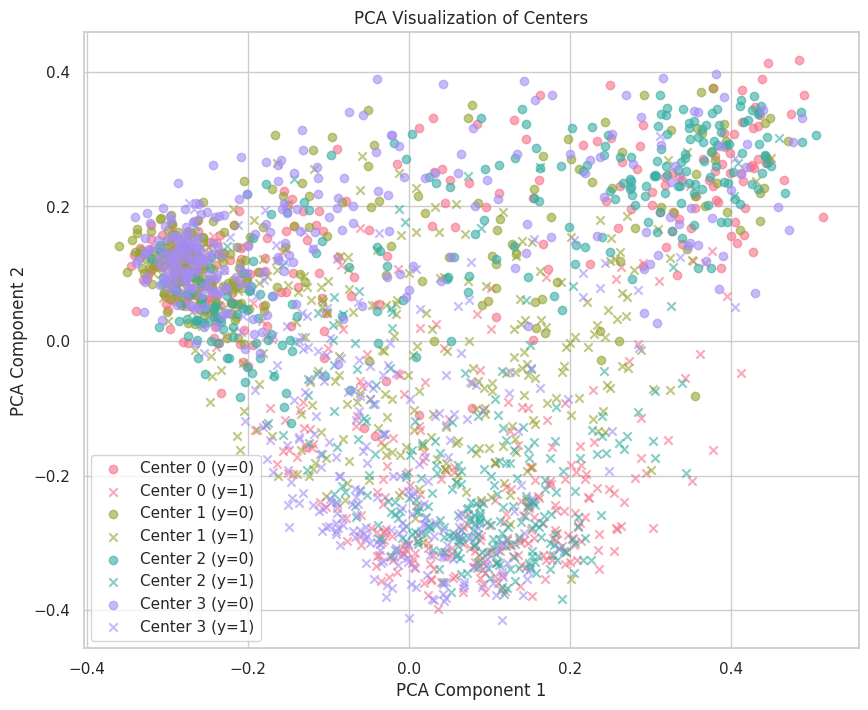

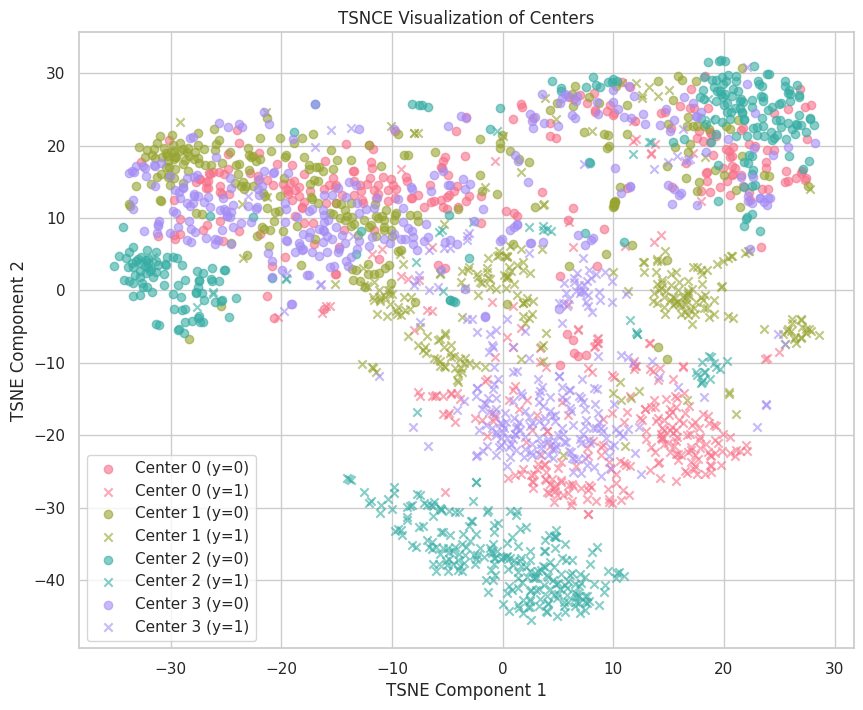

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a color palette
palette = sns.color_palette("husl", len(centers_pca))

# Create a figure
plt.figure(figsize=(10, 8))

# Plot the PCA results for each center
for i, (pca_feats, labels) in enumerate(zip(centers_pca, centers_labels)):
    plt.scatter(
        pca_feats[labels == 0, 0], pca_feats[labels == 0, 1],
        label=f"Center {i} (y=0)", alpha=0.6, color=palette[i], marker='o'
    )
    plt.scatter(
        pca_feats[labels == 1, 0], pca_feats[labels == 1, 1],
        label=f"Center {i} (y=1)", alpha=0.6, color=palette[i], marker='x'
    )

# Add legend
plt.legend()
plt.title("PCA Visualization of Centers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


plt.figure(figsize=(10, 8))

# Plot the tsne results for each center
for i, (tsne_feats, labels) in enumerate(zip(centers_tsne, centers_labels)):
    plt.scatter(
        tsne_feats[labels == 0, 0], tsne_feats[labels == 0, 1],
        label=f"Center {i} (y=0)", alpha=0.6, color=palette[i], marker='o'
    )
    plt.scatter(
        tsne_feats[labels == 1, 0], tsne_feats[labels == 1, 1],
        label=f"Center {i} (y=1)", alpha=0.6, color=palette[i], marker='x'
    )

# Add legend
plt.legend()
plt.title("TSNCE Visualization of Centers")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()

# Exploring triplet learning


anchor = center 0 class 0, positive = center 1/2's class 0, negative = center 1/2's class 1 \
anchor = center 0 class 1, positive = center 1/2's class 1, negative = center 1/2's class 0

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

# ------------------ Adapter Definition ------------------
class Adapter(nn.Module):
    def __init__(self, dim, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, dim),
        )
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x + self.net(x))

# ------------------ Triplet Dataset ------------------

def cosine_dist(x, y):
    # returns 1 − cosine_similarity, so smaller means more similar
    return 1.0 - F.cosine_similarity(x, y, dim=1)

class FeatureTripletDataset(Dataset):
    def __init__(self, features, labels, centers):
        """
        features: np.array [N, D]
        labels:   np.array [N]
        centers:  np.array [N]  # 0,1,2 indicating domain
        """
        self.features = features
        self.labels = labels
        self.centers = centers

        # Precompute indices by (center, label)
        self.by_center_label = {}
        for c in np.unique(centers):
            for lbl in [0, 1]:
                mask = (centers == c) & (labels == lbl)
                self.by_center_label[(c, lbl)] = np.where(mask)[0]

        # Anchors are only from center 0
        self.anchor_idxs = np.concatenate(
            [self.by_center_label[(0, 0)], self.by_center_label[(0, 1)]]
        )

    def __len__(self):
        return len(self.anchor_idxs)

    def __getitem__(self, idx):
        # Anchor from center 0
        a_idx = self.anchor_idxs[idx]
        anchor = self.features[a_idx]
        a_lbl = self.labels[a_idx]

        # Sample positive from centers 1 or 2 with same label
        pos_center = np.random.choice([1, 2])
        pos_idx = np.random.choice(self.by_center_label[(pos_center, a_lbl)])
        positive = self.features[pos_idx]

        # Sample negative: different label from same pos_center
        neg_lbl = 1 - a_lbl
        neg_idx = np.random.choice(self.by_center_label[(pos_center, neg_lbl)])
        negative = self.features[neg_idx]

        return (
            torch.from_numpy(anchor).float(),
            torch.from_numpy(positive).float(),
            torch.from_numpy(negative).float()
        )

# ------------------ Training Loop ------------------
def train_adapter(
    centers_features, centers_labels, device='cuda',
    lr=1e-3, batch_size=128, epochs=20
):
    # Prepare concatenated arrays
    feats = np.concatenate(centers_features)          # [N, D]
    labels = np.concatenate(centers_labels)           # [N]
    centers = np.concatenate(
        [[i] * len(f) for i, f in enumerate(centers_features)]
    )

    dataset = FeatureTripletDataset(feats, labels, centers)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    dim = feats.shape[1]
    adapter = Adapter(dim).to(device)
    triplet_loss_fn = nn.TripletMarginWithDistanceLoss(margin=0.2,distance_function=cosine_dist,reduction='mean')
    # triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)
    optimizer = optim.Adam(adapter.parameters(), lr=lr)

    adapter.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for anchor, positive, negative in tqdm(loader, desc=f"Epoch {epoch+1}"):
            # Move to device
            anchor   = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            # Forward pass through adapter
            out_a = adapter(anchor)
            out_p = adapter(positive)
            out_n = adapter(negative)

            # Triplet loss: align same-class across domains
            L_trip = triplet_loss_fn(out_a, out_p, out_n)

            # Euclidean loss: preserve original center-0 content
            L_euc  = cosine_dist(out_a, anchor).mean()

            # Combine losses
            loss = L_trip + L_euc
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1} — avg loss: {avg_loss:.4f}")

    return adapter

adapter = train_adapter(centers_features[0:3], centers_labels[0:3], device=DEVICE,
                        lr=1e-3, batch_size=32, epochs=200)

torch.save(adapter.state_dict(), 'adapter_weights.pth')

Epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 13.51it/s]


Epoch 1 — avg loss: 0.1818


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 23.21it/s]


Epoch 2 — avg loss: 0.1010


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 19.25it/s]


Epoch 3 — avg loss: 0.0828


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 20.75it/s]


Epoch 4 — avg loss: 0.0733


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 21.22it/s]


Epoch 5 — avg loss: 0.0742


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 25.76it/s]


Epoch 6 — avg loss: 0.0683


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 26.02it/s]


Epoch 7 — avg loss: 0.0652


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 23.05it/s]


Epoch 8 — avg loss: 0.0608


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 25.09it/s]


Epoch 9 — avg loss: 0.0626


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.74it/s]


Epoch 10 — avg loss: 0.0585


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.28it/s]


Epoch 11 — avg loss: 0.0559


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 21.28it/s]


Epoch 12 — avg loss: 0.0575


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s]


Epoch 13 — avg loss: 0.0529


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 17.34it/s]


Epoch 14 — avg loss: 0.0545


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 28.01it/s]


Epoch 15 — avg loss: 0.0531


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 24.42it/s]


Epoch 16 — avg loss: 0.0471


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 24.81it/s]


Epoch 17 — avg loss: 0.0498


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 23.73it/s]


Epoch 18 — avg loss: 0.0440


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 23.26it/s]


Epoch 19 — avg loss: 0.0419


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 23.14it/s]


Epoch 20 — avg loss: 0.0459


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 29.52it/s]


Epoch 21 — avg loss: 0.0455


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 25.40it/s]


Epoch 22 — avg loss: 0.0480


Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 23.47it/s]


Epoch 23 — avg loss: 0.0480


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 27.12it/s]


Epoch 24 — avg loss: 0.0411


Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 22.75it/s]


Epoch 25 — avg loss: 0.0446


Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 23.25it/s]


Epoch 26 — avg loss: 0.0417


Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 26.19it/s]


Epoch 27 — avg loss: 0.0399


Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 24.40it/s]


Epoch 28 — avg loss: 0.0386


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 19.29it/s]


Epoch 29 — avg loss: 0.0351


Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


Epoch 30 — avg loss: 0.0359


Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 19.10it/s]


Epoch 31 — avg loss: 0.0363


Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 24.93it/s]


Epoch 32 — avg loss: 0.0323


Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


Epoch 33 — avg loss: 0.0315


Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 23.62it/s]


Epoch 34 — avg loss: 0.0392


Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 25.22it/s]


Epoch 35 — avg loss: 0.0329


Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 21.16it/s]


Epoch 36 — avg loss: 0.0360


Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 26.15it/s]


Epoch 37 — avg loss: 0.0331


Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 26.00it/s]


Epoch 38 — avg loss: 0.0316


Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 24.11it/s]


Epoch 39 — avg loss: 0.0288


Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 24.55it/s]


Epoch 40 — avg loss: 0.0302


Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 26.18it/s]


Epoch 41 — avg loss: 0.0287


Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 22.89it/s]


Epoch 42 — avg loss: 0.0274


Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 27.09it/s]


Epoch 43 — avg loss: 0.0288


Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 26.70it/s]


Epoch 44 — avg loss: 0.0260


Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 22.66it/s]


Epoch 45 — avg loss: 0.0261


Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 27.59it/s]


Epoch 46 — avg loss: 0.0265


Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 26.99it/s]


Epoch 47 — avg loss: 0.0278


Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 23.21it/s]


Epoch 48 — avg loss: 0.0258


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 28.07it/s]


Epoch 49 — avg loss: 0.0246


Epoch 50: 100%|██████████| 8/8 [00:00<00:00, 26.33it/s]


Epoch 50 — avg loss: 0.0259


Epoch 51: 100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


Epoch 51 — avg loss: 0.0287


Epoch 52: 100%|██████████| 8/8 [00:00<00:00, 28.22it/s]


Epoch 52 — avg loss: 0.0304


Epoch 53: 100%|██████████| 8/8 [00:00<00:00, 23.49it/s]


Epoch 53 — avg loss: 0.0270


Epoch 54: 100%|██████████| 8/8 [00:00<00:00, 25.58it/s]


Epoch 54 — avg loss: 0.0251


Epoch 55: 100%|██████████| 8/8 [00:00<00:00, 26.11it/s]


Epoch 55 — avg loss: 0.0273


Epoch 56: 100%|██████████| 8/8 [00:00<00:00, 26.33it/s]


Epoch 56 — avg loss: 0.0272


Epoch 57: 100%|██████████| 8/8 [00:00<00:00, 23.42it/s]


Epoch 57 — avg loss: 0.0243


Epoch 58: 100%|██████████| 8/8 [00:00<00:00, 27.77it/s]


Epoch 58 — avg loss: 0.0252


Epoch 59: 100%|██████████| 8/8 [00:00<00:00, 27.93it/s]


Epoch 59 — avg loss: 0.0257


Epoch 60: 100%|██████████| 8/8 [00:00<00:00, 25.34it/s]


Epoch 60 — avg loss: 0.0253


Epoch 61: 100%|██████████| 8/8 [00:00<00:00, 26.36it/s]


Epoch 61 — avg loss: 0.0230


Epoch 62: 100%|██████████| 8/8 [00:00<00:00, 27.47it/s]


Epoch 62 — avg loss: 0.0261


Epoch 63: 100%|██████████| 8/8 [00:00<00:00, 26.33it/s]


Epoch 63 — avg loss: 0.0238


Epoch 64: 100%|██████████| 8/8 [00:00<00:00, 22.45it/s]


Epoch 64 — avg loss: 0.0248


Epoch 65: 100%|██████████| 8/8 [00:00<00:00, 26.07it/s]


Epoch 65 — avg loss: 0.0283


Epoch 66: 100%|██████████| 8/8 [00:00<00:00, 23.93it/s]


Epoch 66 — avg loss: 0.0224


Epoch 67: 100%|██████████| 8/8 [00:00<00:00, 24.11it/s]


Epoch 67 — avg loss: 0.0241


Epoch 68: 100%|██████████| 8/8 [00:00<00:00, 26.71it/s]


Epoch 68 — avg loss: 0.0215


Epoch 69: 100%|██████████| 8/8 [00:00<00:00, 23.54it/s]


Epoch 69 — avg loss: 0.0272


Epoch 70: 100%|██████████| 8/8 [00:00<00:00, 25.52it/s]


Epoch 70 — avg loss: 0.0219


Epoch 71: 100%|██████████| 8/8 [00:00<00:00, 25.45it/s]


Epoch 71 — avg loss: 0.0242


Epoch 72: 100%|██████████| 8/8 [00:00<00:00, 22.93it/s]


Epoch 72 — avg loss: 0.0240


Epoch 73: 100%|██████████| 8/8 [00:00<00:00, 24.67it/s]


Epoch 73 — avg loss: 0.0245


Epoch 74: 100%|██████████| 8/8 [00:00<00:00, 21.97it/s]


Epoch 74 — avg loss: 0.0225


Epoch 75: 100%|██████████| 8/8 [00:00<00:00, 19.89it/s]


Epoch 75 — avg loss: 0.0230


Epoch 76: 100%|██████████| 8/8 [00:00<00:00, 25.81it/s]


Epoch 76 — avg loss: 0.0223


Epoch 77: 100%|██████████| 8/8 [00:00<00:00, 24.37it/s]


Epoch 77 — avg loss: 0.0207


Epoch 78: 100%|██████████| 8/8 [00:00<00:00, 23.81it/s]


Epoch 78 — avg loss: 0.0234


Epoch 79: 100%|██████████| 8/8 [00:00<00:00, 26.31it/s]


Epoch 79 — avg loss: 0.0230


Epoch 80: 100%|██████████| 8/8 [00:00<00:00, 25.25it/s]


Epoch 80 — avg loss: 0.0222


Epoch 81: 100%|██████████| 8/8 [00:00<00:00, 23.72it/s]


Epoch 81 — avg loss: 0.0240


Epoch 82: 100%|██████████| 8/8 [00:00<00:00, 23.43it/s]


Epoch 82 — avg loss: 0.0207


Epoch 83: 100%|██████████| 8/8 [00:00<00:00, 20.30it/s]


Epoch 83 — avg loss: 0.0248


Epoch 84: 100%|██████████| 8/8 [00:00<00:00, 24.25it/s]


Epoch 84 — avg loss: 0.0256


Epoch 85: 100%|██████████| 8/8 [00:00<00:00, 27.35it/s]


Epoch 85 — avg loss: 0.0214


Epoch 86: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


Epoch 86 — avg loss: 0.0221


Epoch 87: 100%|██████████| 8/8 [00:00<00:00, 26.51it/s]


Epoch 87 — avg loss: 0.0208


Epoch 88: 100%|██████████| 8/8 [00:00<00:00, 23.52it/s]


Epoch 88 — avg loss: 0.0193


Epoch 89: 100%|██████████| 8/8 [00:00<00:00, 23.70it/s]


Epoch 89 — avg loss: 0.0206


Epoch 90: 100%|██████████| 8/8 [00:00<00:00, 27.41it/s]


Epoch 90 — avg loss: 0.0202


Epoch 91: 100%|██████████| 8/8 [00:00<00:00, 24.40it/s]


Epoch 91 — avg loss: 0.0187


Epoch 92: 100%|██████████| 8/8 [00:00<00:00, 18.91it/s]


Epoch 92 — avg loss: 0.0223


Epoch 93: 100%|██████████| 8/8 [00:00<00:00, 25.70it/s]


Epoch 93 — avg loss: 0.0192


Epoch 94: 100%|██████████| 8/8 [00:00<00:00, 23.76it/s]


Epoch 94 — avg loss: 0.0199


Epoch 95: 100%|██████████| 8/8 [00:00<00:00, 27.55it/s]


Epoch 95 — avg loss: 0.0209


Epoch 96: 100%|██████████| 8/8 [00:00<00:00, 24.62it/s]


Epoch 96 — avg loss: 0.0191


Epoch 97: 100%|██████████| 8/8 [00:00<00:00, 23.04it/s]


Epoch 97 — avg loss: 0.0185


Epoch 98: 100%|██████████| 8/8 [00:00<00:00, 28.18it/s]


Epoch 98 — avg loss: 0.0192


Epoch 99: 100%|██████████| 8/8 [00:00<00:00, 24.81it/s]


Epoch 99 — avg loss: 0.0169


Epoch 100: 100%|██████████| 8/8 [00:00<00:00, 23.03it/s]


Epoch 100 — avg loss: 0.0164


Epoch 101: 100%|██████████| 8/8 [00:00<00:00, 21.71it/s]


Epoch 101 — avg loss: 0.0188


Epoch 102: 100%|██████████| 8/8 [00:00<00:00, 22.99it/s]


Epoch 102 — avg loss: 0.0180


Epoch 103: 100%|██████████| 8/8 [00:00<00:00, 23.29it/s]


Epoch 103 — avg loss: 0.0173


Epoch 104: 100%|██████████| 8/8 [00:00<00:00, 25.70it/s]


Epoch 104 — avg loss: 0.0178


Epoch 105: 100%|██████████| 8/8 [00:00<00:00, 26.14it/s]


Epoch 105 — avg loss: 0.0216


Epoch 106: 100%|██████████| 8/8 [00:00<00:00, 24.62it/s]


Epoch 106 — avg loss: 0.0208


Epoch 107: 100%|██████████| 8/8 [00:00<00:00, 29.39it/s]


Epoch 107 — avg loss: 0.0192


Epoch 108: 100%|██████████| 8/8 [00:00<00:00, 27.07it/s]


Epoch 108 — avg loss: 0.0208


Epoch 109: 100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


Epoch 109 — avg loss: 0.0212


Epoch 110: 100%|██████████| 8/8 [00:00<00:00, 25.65it/s]


Epoch 110 — avg loss: 0.0181


Epoch 111: 100%|██████████| 8/8 [00:00<00:00, 25.48it/s]


Epoch 111 — avg loss: 0.0218


Epoch 112: 100%|██████████| 8/8 [00:00<00:00, 22.08it/s]


Epoch 112 — avg loss: 0.0191


Epoch 113: 100%|██████████| 8/8 [00:00<00:00, 20.38it/s]


Epoch 113 — avg loss: 0.0184


Epoch 114: 100%|██████████| 8/8 [00:00<00:00, 15.93it/s]


Epoch 114 — avg loss: 0.0172


Epoch 115: 100%|██████████| 8/8 [00:00<00:00, 22.01it/s]


Epoch 115 — avg loss: 0.0191


Epoch 116: 100%|██████████| 8/8 [00:00<00:00, 26.95it/s]


Epoch 116 — avg loss: 0.0184


Epoch 117: 100%|██████████| 8/8 [00:00<00:00, 27.46it/s]


Epoch 117 — avg loss: 0.0172


Epoch 118: 100%|██████████| 8/8 [00:00<00:00, 22.19it/s]


Epoch 118 — avg loss: 0.0172


Epoch 119: 100%|██████████| 8/8 [00:00<00:00, 23.52it/s]


Epoch 119 — avg loss: 0.0188


Epoch 120: 100%|██████████| 8/8 [00:00<00:00, 22.03it/s]


Epoch 120 — avg loss: 0.0163


Epoch 121: 100%|██████████| 8/8 [00:00<00:00, 27.02it/s]


Epoch 121 — avg loss: 0.0175


Epoch 122: 100%|██████████| 8/8 [00:00<00:00, 25.07it/s]


Epoch 122 — avg loss: 0.0184


Epoch 123: 100%|██████████| 8/8 [00:00<00:00, 25.25it/s]


Epoch 123 — avg loss: 0.0166


Epoch 124: 100%|██████████| 8/8 [00:00<00:00, 29.20it/s]


Epoch 124 — avg loss: 0.0157


Epoch 125: 100%|██████████| 8/8 [00:00<00:00, 27.17it/s]


Epoch 125 — avg loss: 0.0165


Epoch 126: 100%|██████████| 8/8 [00:00<00:00, 24.86it/s]


Epoch 126 — avg loss: 0.0157


Epoch 127: 100%|██████████| 8/8 [00:00<00:00, 25.84it/s]


Epoch 127 — avg loss: 0.0166


Epoch 128: 100%|██████████| 8/8 [00:00<00:00, 26.67it/s]


Epoch 128 — avg loss: 0.0190


Epoch 129: 100%|██████████| 8/8 [00:00<00:00, 27.83it/s]


Epoch 129 — avg loss: 0.0152


Epoch 130: 100%|██████████| 8/8 [00:00<00:00, 26.09it/s]


Epoch 130 — avg loss: 0.0153


Epoch 131: 100%|██████████| 8/8 [00:00<00:00, 25.11it/s]


Epoch 131 — avg loss: 0.0150


Epoch 132: 100%|██████████| 8/8 [00:00<00:00, 25.47it/s]


Epoch 132 — avg loss: 0.0153


Epoch 133: 100%|██████████| 8/8 [00:00<00:00, 25.18it/s]


Epoch 133 — avg loss: 0.0155


Epoch 134: 100%|██████████| 8/8 [00:00<00:00, 25.19it/s]


Epoch 134 — avg loss: 0.0151


Epoch 135: 100%|██████████| 8/8 [00:00<00:00, 27.00it/s]


Epoch 135 — avg loss: 0.0171


Epoch 136: 100%|██████████| 8/8 [00:00<00:00, 20.47it/s]


Epoch 136 — avg loss: 0.0198


Epoch 137: 100%|██████████| 8/8 [00:00<00:00, 25.51it/s]


Epoch 137 — avg loss: 0.0172


Epoch 138: 100%|██████████| 8/8 [00:00<00:00, 23.64it/s]


Epoch 138 — avg loss: 0.0212


Epoch 139: 100%|██████████| 8/8 [00:00<00:00, 26.51it/s]


Epoch 139 — avg loss: 0.0172


Epoch 140: 100%|██████████| 8/8 [00:00<00:00, 25.69it/s]


Epoch 140 — avg loss: 0.0160


Epoch 141: 100%|██████████| 8/8 [00:00<00:00, 24.20it/s]


Epoch 141 — avg loss: 0.0158


Epoch 142: 100%|██████████| 8/8 [00:00<00:00, 27.17it/s]


Epoch 142 — avg loss: 0.0169


Epoch 143: 100%|██████████| 8/8 [00:00<00:00, 26.06it/s]


Epoch 143 — avg loss: 0.0160


Epoch 144: 100%|██████████| 8/8 [00:00<00:00, 25.81it/s]


Epoch 144 — avg loss: 0.0172


Epoch 145: 100%|██████████| 8/8 [00:00<00:00, 26.21it/s]


Epoch 145 — avg loss: 0.0155


Epoch 146: 100%|██████████| 8/8 [00:00<00:00, 27.48it/s]


Epoch 146 — avg loss: 0.0177


Epoch 147: 100%|██████████| 8/8 [00:00<00:00, 27.20it/s]


Epoch 147 — avg loss: 0.0166


Epoch 148: 100%|██████████| 8/8 [00:00<00:00, 26.99it/s]


Epoch 148 — avg loss: 0.0144


Epoch 149: 100%|██████████| 8/8 [00:00<00:00, 30.85it/s]


Epoch 149 — avg loss: 0.0185


Epoch 150: 100%|██████████| 8/8 [00:00<00:00, 29.06it/s]


Epoch 150 — avg loss: 0.0143


Epoch 151: 100%|██████████| 8/8 [00:00<00:00, 25.22it/s]


Epoch 151 — avg loss: 0.0184


Epoch 152: 100%|██████████| 8/8 [00:00<00:00, 28.06it/s]


Epoch 152 — avg loss: 0.0203


Epoch 153: 100%|██████████| 8/8 [00:00<00:00, 26.77it/s]


Epoch 153 — avg loss: 0.0149


Epoch 154: 100%|██████████| 8/8 [00:00<00:00, 24.65it/s]


Epoch 154 — avg loss: 0.0159


Epoch 155: 100%|██████████| 8/8 [00:00<00:00, 26.89it/s]


Epoch 155 — avg loss: 0.0164


Epoch 156: 100%|██████████| 8/8 [00:00<00:00, 28.67it/s]


Epoch 156 — avg loss: 0.0137


Epoch 157: 100%|██████████| 8/8 [00:00<00:00, 26.11it/s]


Epoch 157 — avg loss: 0.0161


Epoch 158: 100%|██████████| 8/8 [00:00<00:00, 27.09it/s]


Epoch 158 — avg loss: 0.0145


Epoch 159: 100%|██████████| 8/8 [00:00<00:00, 28.59it/s]


Epoch 159 — avg loss: 0.0137


Epoch 160: 100%|██████████| 8/8 [00:00<00:00, 26.63it/s]


Epoch 160 — avg loss: 0.0135


Epoch 161: 100%|██████████| 8/8 [00:00<00:00, 27.40it/s]


Epoch 161 — avg loss: 0.0127


Epoch 162: 100%|██████████| 8/8 [00:00<00:00, 26.45it/s]


Epoch 162 — avg loss: 0.0167


Epoch 163: 100%|██████████| 8/8 [00:00<00:00, 29.10it/s]


Epoch 163 — avg loss: 0.0155


Epoch 164: 100%|██████████| 8/8 [00:00<00:00, 28.24it/s]


Epoch 164 — avg loss: 0.0136


Epoch 165: 100%|██████████| 8/8 [00:00<00:00, 31.69it/s]


Epoch 165 — avg loss: 0.0151


Epoch 166: 100%|██████████| 8/8 [00:00<00:00, 29.39it/s]


Epoch 166 — avg loss: 0.0146


Epoch 167: 100%|██████████| 8/8 [00:00<00:00, 27.36it/s]


Epoch 167 — avg loss: 0.0114


Epoch 168: 100%|██████████| 8/8 [00:00<00:00, 30.29it/s]


Epoch 168 — avg loss: 0.0174


Epoch 169: 100%|██████████| 8/8 [00:00<00:00, 26.20it/s]


Epoch 169 — avg loss: 0.0123


Epoch 170: 100%|██████████| 8/8 [00:00<00:00, 22.05it/s]


Epoch 170 — avg loss: 0.0149


Epoch 171: 100%|██████████| 8/8 [00:00<00:00, 23.03it/s]


Epoch 171 — avg loss: 0.0131


Epoch 172: 100%|██████████| 8/8 [00:00<00:00, 17.72it/s]


Epoch 172 — avg loss: 0.0131


Epoch 173: 100%|██████████| 8/8 [00:00<00:00, 19.90it/s]


Epoch 173 — avg loss: 0.0159


Epoch 174: 100%|██████████| 8/8 [00:00<00:00, 21.32it/s]


Epoch 174 — avg loss: 0.0142


Epoch 175: 100%|██████████| 8/8 [00:00<00:00, 21.36it/s]


Epoch 175 — avg loss: 0.0138


Epoch 176: 100%|██████████| 8/8 [00:00<00:00, 23.79it/s]


Epoch 176 — avg loss: 0.0133


Epoch 177: 100%|██████████| 8/8 [00:00<00:00, 24.09it/s]


Epoch 177 — avg loss: 0.0141


Epoch 178: 100%|██████████| 8/8 [00:00<00:00, 20.41it/s]


Epoch 178 — avg loss: 0.0132


Epoch 179: 100%|██████████| 8/8 [00:00<00:00, 28.13it/s]


Epoch 179 — avg loss: 0.0140


Epoch 180: 100%|██████████| 8/8 [00:00<00:00, 27.62it/s]


Epoch 180 — avg loss: 0.0161


Epoch 181: 100%|██████████| 8/8 [00:00<00:00, 25.75it/s]


Epoch 181 — avg loss: 0.0121


Epoch 182: 100%|██████████| 8/8 [00:00<00:00, 27.79it/s]


Epoch 182 — avg loss: 0.0141


Epoch 183: 100%|██████████| 8/8 [00:00<00:00, 27.61it/s]


Epoch 183 — avg loss: 0.0131


Epoch 184: 100%|██████████| 8/8 [00:00<00:00, 25.46it/s]


Epoch 184 — avg loss: 0.0167


Epoch 185: 100%|██████████| 8/8 [00:00<00:00, 24.89it/s]


Epoch 185 — avg loss: 0.0148


Epoch 186: 100%|██████████| 8/8 [00:00<00:00, 24.99it/s]


Epoch 186 — avg loss: 0.0137


Epoch 187: 100%|██████████| 8/8 [00:00<00:00, 27.55it/s]


Epoch 187 — avg loss: 0.0134


Epoch 188: 100%|██████████| 8/8 [00:00<00:00, 29.03it/s]


Epoch 188 — avg loss: 0.0145


Epoch 189: 100%|██████████| 8/8 [00:00<00:00, 29.29it/s]


Epoch 189 — avg loss: 0.0111


Epoch 190: 100%|██████████| 8/8 [00:00<00:00, 20.87it/s]


Epoch 190 — avg loss: 0.0145


Epoch 191: 100%|██████████| 8/8 [00:00<00:00, 22.13it/s]


Epoch 191 — avg loss: 0.0130


Epoch 192: 100%|██████████| 8/8 [00:00<00:00, 19.78it/s]


Epoch 192 — avg loss: 0.0132


Epoch 193: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 193 — avg loss: 0.0141


Epoch 194: 100%|██████████| 8/8 [00:00<00:00, 17.19it/s]


Epoch 194 — avg loss: 0.0136


Epoch 195: 100%|██████████| 8/8 [00:00<00:00, 18.98it/s]


Epoch 195 — avg loss: 0.0125


Epoch 196: 100%|██████████| 8/8 [00:00<00:00, 25.17it/s]


Epoch 196 — avg loss: 0.0107


Epoch 197: 100%|██████████| 8/8 [00:00<00:00, 26.63it/s]


Epoch 197 — avg loss: 0.0137


Epoch 198: 100%|██████████| 8/8 [00:00<00:00, 27.84it/s]


Epoch 198 — avg loss: 0.0121


Epoch 199: 100%|██████████| 8/8 [00:00<00:00, 24.50it/s]


Epoch 199 — avg loss: 0.0104


Epoch 200: 100%|██████████| 8/8 [00:00<00:00, 28.19it/s]

Epoch 200 — avg loss: 0.0109


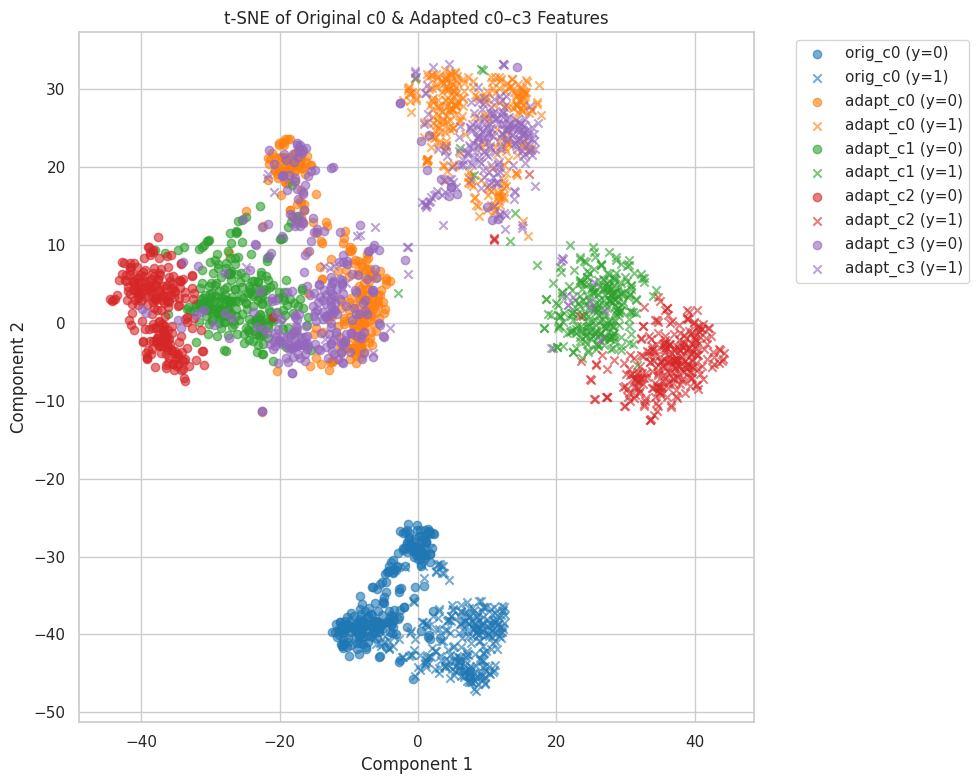

In [9]:
def visualize_all_original_and_adapted(
    centers_features, centers_labels, adapter,
    perplexity=50, device=DEVICE
):
    # Ensure adapter on correct device
    device = device or next(adapter.parameters()).device
    adapter.eval()
    
    # 1) Collect original center0
    orig_feats = centers_features[0]
    orig_labels = centers_labels[0]
    
    # 2) Compute adapted features for centers 0–3
    adapted_feats, adapted_labels = [], []
    with torch.no_grad():
        for feats, labels in zip(centers_features, centers_labels):
            x = torch.from_numpy(feats).float().to(device)
            out = adapter(x).cpu().numpy()
            adapted_feats.append(out)
            adapted_labels.append(labels)
    
    # 3) Stack into one big array: [orig_c0, adapt_c0, adapt_c1, adapt_c2, adapt_c3]
    blocks = [orig_feats] + adapted_feats
    label_blocks = [orig_labels] + adapted_labels
    group_names = ["orig_c0"] + [f"adapt_c{i}" for i in range(len(adapted_feats))]
    
    data = np.vstack(blocks)
    tsne = TSNE(n_components=2, perplexity=perplexity)
    emb = tsne.fit_transform(data)
    
    # 4) Split back out and plot
    sns.set(style="whitegrid")
    palette = sns.color_palette("tab10", len(blocks))
    plt.figure(figsize=(10,8))
    
    start = 0
    for grp_idx, (feats_block, lbl_block, color, name) in enumerate(
        zip(blocks, label_blocks, palette, group_names)
    ):
        n = feats_block.shape[0]
        seg = emb[start:start+n]
        for cls, marker in zip([0,1], ["o","x"]):
            mask = lbl_block == cls
            plt.scatter(
                seg[mask,0], seg[mask,1],
                label=f"{name} (y={cls})",
                alpha=0.6, color=color, marker=marker
            )
        start += n
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title("t-SNE of Original c0 & Adapted c0–c3 Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

# Usage
visualize_all_original_and_adapted(
    centers_features, centers_labels, adapter,
    perplexity=50, device=DEVICE
)


In [17]:
torch.save(adapter.state_dict(), "adapter_weights.pth")

# Domain Shift Plots

In [ ]:
# get the text features -> text_feats
text_prompts = [
    "a patch of breast tissue with no tumor",
    "a patch of breast tissue with tumor"
]

text_tokens = tokenizer(text_prompts).to(DEVICE)
text_feats = model.encode_text(text_tokens)
text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
text_feats = text_feats.cpu().numpy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from math import ceil

# Assume centers_features, centers_labels, and text_feats are defined in the environment

# Extract embeddings
positive_embedding = text_feats[1]
negative_embedding = text_feats[0]

n_centers = len(centers_features)
x_min, x_max = 1, -1  # initialize for global axis limits

# Precompute distributions
pos_label_dists = []  # for center-positive samples
neg_label_dists = []  # for center-negative samples
for feats, labels in zip(centers_features, centers_labels):
    feats = np.array(feats)
    norms = feats / np.linalg.norm(feats, axis=1, keepdims=True)
    labels = np.array(labels)
    
    # Positive-labeled samples
    mask_p = labels == 1
    if mask_p.sum() > 1:
        vals_pp = norms[mask_p].dot(positive_embedding)
        vals_pn = norms[mask_p].dot(negative_embedding)
    else:
        vals_pp = np.array([])
        vals_pn = np.array([])
    pos_label_dists.append((vals_pp, vals_pn))
    
    # Negative-labeled samples
    mask_n = labels == 0
    if mask_n.sum() > 1:
        vals_np = norms[mask_n].dot(positive_embedding)
        vals_nn = norms[mask_n].dot(negative_embedding)
    else:
        vals_np = np.array([])
        vals_nn = np.array([])
    neg_label_dists.append((vals_np, vals_nn))
    
    # update global limits
    all_vals = np.concatenate([vals_pp, vals_pn, vals_np, vals_nn])
    if all_vals.size:
        x_min = min(x_min, all_vals.min())
        x_max = max(x_max, all_vals.max())

x_grid = np.linspace(x_min, x_max, 200)

# Plot for positive-labeled samples
fig, axes = plt.subplots(1, n_centers, figsize=(5 * n_centers, 4), sharex=True, sharey=True)
axes = axes if n_centers > 1 else [axes]
for idx, ax in enumerate(axes):
    vals_pp, vals_pn = pos_label_dists[idx]
    if vals_pp.size > 1:
        kde_pp = gaussian_kde(vals_pp)
        ax.plot(x_grid, kde_pp(x_grid), label='Positive prompt')
    if vals_pn.size > 1:
        kde_pn = gaussian_kde(vals_pn)
        ax.plot(x_grid, kde_pn(x_grid), label='Negative prompt')
    ax.set_title(f'Center {idx} (label=1)')
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Density')
    ax.legend()
fig.suptitle('Distributions for Positive-Labeled Samples', y=1.02)
plt.tight_layout()

# Plot for negative-labeled samples
fig, axes = plt.subplots(1, n_centers, figsize=(5 * n_centers, 4), sharex=True, sharey=True)
axes = axes if n_centers > 1 else [axes]
for idx, ax in enumerate(axes):
    vals_np, vals_nn = neg_label_dists[idx]
    if vals_np.size > 1:
        kde_np = gaussian_kde(vals_np)
        ax.plot(x_grid, kde_np(x_grid), label='Positive prompt')
    if vals_nn.size > 1:
        kde_nn = gaussian_kde(vals_nn)
        ax.plot(x_grid, kde_nn(x_grid), label='Negative prompt')
    ax.set_title(f'Center {idx} (label=0)')
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Density')
    ax.legend()
fig.suptitle('Distributions for Negative-Labeled Samples', y=1.02)
plt.tight_layout()

plt.show()



import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# Assume centers_features, centers_labels, and text_feats are defined in the environment

# Extract embeddings
positive_embedding = text_feats[1]
negative_embedding = text_feats[0]

n_centers = len(centers_features)
fig, axes = plt.subplots(1, n_centers, figsize=(5 * n_centers, 5), sharex=True, sharey=True)
axes = axes if n_centers > 1 else [axes]

for idx, ax in enumerate(axes):
    feats = np.array(centers_features[idx])
    labels = np.array(centers_labels[idx])
    if feats.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'Center {idx}')
        continue

    # Normalize features
    feats_norm = feats / np.linalg.norm(feats, axis=1, keepdims=True)

    # Compute cosine similarities
    cos_pos = feats_norm.dot(positive_embedding)
    cos_neg = feats_norm.dot(negative_embedding)

    # Scatter plot
    mask_pos = labels == 1
    mask_neg = labels == 0
    ax.scatter(cos_pos[mask_pos], cos_neg[mask_pos], c='red', label='y=1', alpha=0.3)
    ax.scatter(cos_pos[mask_neg], cos_neg[mask_neg], c='blue', label='y=0', alpha=0.3)

    ax.set_title(f'Center {idx}')
    ax.set_xlabel('Cosine to Positive Prompt')
    ax.set_ylabel('Cosine to Negative Prompt')
    ax.legend()

# Set equal aspect for comparison
plt.tight_layout()
plt.show()

# with adapter

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Prepare adapter and text embeddings ---
adapter.eval()                      # freeze adapter
with torch.no_grad():
    # convert text_feats → torch → adapter → normalize → back to numpy
    t = torch.from_numpy(text_feats).to(DEVICE)           # (2, D)
    adapted_t = adapter(t)                                # (2, D)
    adapted_t = adapted_t / adapted_t.norm(dim=1, keepdim=True)
    adapted_t = adapted_t.cpu().numpy()

positive_embedding = adapted_t[1]
negative_embedding = adapted_t[0]

# --- 2) Scatter plot per center, with adapter on the fly ---
n_centers = len(centers_features)
fig, axes = plt.subplots(1, n_centers, figsize=(5 * n_centers, 5), sharex=True, sharey=True)
axes = axes if n_centers > 1 else [axes]

for idx, ax in enumerate(axes):
    feats = np.array(centers_features[idx])   # (N_i, D)
    labels = np.array(centers_labels[idx])    # (N_i,)

    if feats.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'Center {idx}')
        continue

    # 2.1) Adapt image feats
    with torch.no_grad():
        f = torch.from_numpy(feats).to(DEVICE)         # (N_i, D)
        f_adapt = adapter(f)                           # (N_i, D)
        f_adapt = f_adapt / f_adapt.norm(dim=1, keepdim=True)
        feats_norm = f_adapt.cpu().numpy()

    # 2.2) Compute cosines
    cos_pos = feats_norm.dot(positive_embedding)      # (N_i,)
    cos_neg = feats_norm.dot(negative_embedding)      # (N_i,)

    # 2.3) Scatter
    mask_pos = labels == 1
    mask_neg = labels == 0
    ax.scatter(cos_pos[mask_pos], cos_neg[mask_pos], c='red',   label='y=1', alpha=0.3)
    ax.scatter(cos_pos[mask_neg], cos_neg[mask_neg], c='blue',  label='y=0', alpha=0.3)

    ax.set_title(f'Center {idx}')
    ax.set_xlabel('Cosine to Positive Prompt')
    ax.set_ylabel('Cosine to Negative Prompt')
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Ensure adapter is in eval mode
adapter.eval()

# Adapt text embeddings
with torch.no_grad():
    text_tensor = torch.from_numpy(text_feats).to(next(adapter.parameters()).device)  # (2, D)
    adapted_text = adapter(text_tensor)
    adapted_text = adapted_text / adapted_text.norm(dim=1, keepdim=True)
    adapted_text = adapted_text.cpu().numpy()

positive_embedding = adapted_text[1]
negative_embedding = adapted_text[0]

# Precompute adapted distributions
pos_label_dists = []
neg_label_dists = []
x_min, x_max = 1, -1

for feats, labels in zip(centers_features, centers_labels):
    feats = np.array(feats)
    labels = np.array(labels)
    if feats.size == 0:
        pos_label_dists.append((np.array([]), np.array([])))
        neg_label_dists.append((np.array([]), np.array([])))
        continue

    # Adapt image features
    with torch.no_grad():
        f_tensor = torch.from_numpy(feats).to(next(adapter.parameters()).device)
        adapted_f = adapter(f_tensor)
        adapted_f = adapted_f / adapted_f.norm(dim=1, keepdim=True)
        feats_norm = adapted_f.cpu().numpy()

    # Positive-labeled
    mask_p = labels == 1
    if mask_p.sum() > 1:
        vals_pp = feats_norm[mask_p].dot(positive_embedding)
        vals_pn = feats_norm[mask_p].dot(negative_embedding)
    else:
        vals_pp, vals_pn = np.array([]), np.array([])
    pos_label_dists.append((vals_pp, vals_pn))

    # Negative-labeled
    mask_n = labels == 0
    if mask_n.sum() > 1:
        vals_np = feats_norm[mask_n].dot(positive_embedding)
        vals_nn = feats_norm[mask_n].dot(negative_embedding)
    else:
        vals_np, vals_nn = np.array([]), np.array([])
    neg_label_dists.append((vals_np, vals_nn))

    # Update global limits
    all_vals = np.concatenate([vals_pp, vals_pn, vals_np, vals_nn])
    if all_vals.size:
        x_min = min(x_min, all_vals.min())
        x_max = max(x_max, all_vals.max())

x_grid = np.linspace(x_min, x_max, 200)
n_centers = len(centers_features)

# Plot for positive-labeled samples
fig, axes = plt.subplots(1, n_centers, figsize=(5 * n_centers, 4), sharex=True, sharey=True)
axes = axes if n_centers > 1 else [axes]
for idx, ax in enumerate(axes):
    vals_pp, vals_pn = pos_label_dists[idx]
    if vals_pp.size > 1:
        ax.plot(x_grid, gaussian_kde(vals_pp)(x_grid), label='Adapted Positive prompt')
    if vals_pn.size > 1:
        ax.plot(x_grid, gaussian_kde(vals_pn)(x_grid), label='Adapted Negative prompt')
    ax.set_title(f'Center {idx} (y=1)')
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Density')
    ax.legend()
fig.suptitle('Adapted Distributions for Positive-Labeled Samples', y=1.02)
plt.tight_layout()

# Plot for negative-labeled samples
fig, axes = plt.subplots(1, n_centers, figsize=(5 * n_centers, 4), sharex=True, sharey=True)
axes = axes if n_centers > 1 else [axes]
for idx, ax in enumerate(axes):
    vals_np, vals_nn = neg_label_dists[idx]
    if vals_np.size > 1:
        ax.plot(x_grid, gaussian_kde(vals_np)(x_grid), label='Adapted Positive prompt')
    if vals_nn.size > 1:
        ax.plot(x_grid, gaussian_kde(vals_nn)(x_grid), label='Adapted Negative prompt')
    ax.set_title(f'Center {idx} (y=0)')
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Density')
    ax.legend()
fig.suptitle('Adapted Distributions for Negative-Labeled Samples', y=1.02)
plt.tight_layout()
plt.show()
